# The Applied Data Science Capstone Project Notebook

## Exploration for new restaurant in Denver

## Introduction/Business Problem

A chef/restaurant owner would like to open a new restaurant in downtown Denver.   She wants to locate the restaurant near breweries since her food will complement nicely with local brews.  Her wish for a location is to be near breweries that are well rated and have many people going to them since that will help get people to her location.  The task here is to help find such a location.

## Data

We will leverage Foursquare results to explore breweries within a certain radius of location in downtown Denver.  After making the identification of these breweries, we will pull more information from Fourquare, including ratings, the number of 'likes', the number of pictures taken, and the number of 'likes'.  

In [1]:
# Import modules for the project
import pandas as pd
import numpy as np
import requests

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt 

# import modules for clustering stage
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster

import pylab
import scipy
import scipy.cluster.hierarchy
from scipy.cluster import hierarchy
from scipy import ndimage  
from scipy.spatial import distance_matrix 

import folium # map rendering library

In [44]:
CLIENT_ID = 'x' # your Foursquare ID
CLIENT_SECRET = 'x' # your Foursquare Secret
ACCESS_TOKEN = 'x' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [3]:
# Denver
latitude = 39.731
longitude = -104.988

search_query = 'brewing'
radius = 5000
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

In [4]:
# Get the initial list of breweries from Foursquare within our search radius
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = pd.json_normalize(venues)

# How many results does this return?
print (dataframe.shape)

(49, 25)


In [5]:
# Make a map of the initial results

map_denver = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, name in zip(dataframe['location.lat'], dataframe['location.lng'], dataframe['name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

In [6]:
# Here's a quick routine to grab detailed information from each brewery

def getBreweries(ids):
    
    brewery_list=[]
    for id in ids:
        print(id)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(id,CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)
           
        # make the GET request
        results2 = requests.get(url).json()
        breweries = results2['response']['venue']  #forgot to do this part on initial run, not sure if works
        brewery_list.append(breweries)   #had results2 here

    wanted = pd.DataFrame(brewery_list)
    
    return(wanted)

In [7]:
# Use the dataframe of the initial list to get the detailed information
Denver_breweries = getBreweries(ids=dataframe['id'])

4e07a5a1d22d658532a784d4
5c27fded5bc27d0025e6e05b
40e0b100f964a5202c041fe3
57479d57498e2fafe38a8479
4b9e9835f964a52062f236e3
54580a0a498e9f3cb6354a86
5ae76e5586bc490039f7089b
4be16a4a0f03a593972d19b4
57535102498eb5969014098f
4f63fba1e4b036e3e792341d
5801846038fae01799719b1f
4e84eec3d3e34ff8f6f467b0
5b47d04db5cb76002ccc6c05
578bcb66498e943994037018
540b8d5c498ebc7a3b1e1474
520d52d211d278f948e618f3
53c1d4ea498e3a62e89b5da4
54824f05498eec6494ea864d
601f10a23a91972ffe3f243d
4ee2263f4fc6a6fab58d9d4d
4f775694be7732e03d5bf971
5466d279498e241bb62c3b8c
5078dceee4b06fd3a96dd883
4d74f9179d2fa143fa56f9d6
57dc306a498e8c5231886c31
606ba5ee8b9d271de0a4ef5b
5956b528f427de4e1b23a291
55870d43498ee7321397dd4d
5c27e76d47f876002ccc373f
596e39ed002f4c511e05160e
559ed30f498e392d54782100
5d6d4197a27e1a0007831f82
540e0954498e77f0f9129eb5
5b837cfcb1538e002ce99d3b
595548f5f79faa61873ab103
5869b0a40037eb494478ed13
586f20655a5869791c5153e6
4fa30ee8e4b01ab96b38c775
54580b6f498e35b5c46dcc4e
598a82519d6a193905be9d99


In [8]:
Denver_breweries.columns   #What is in the new dataframe?

Index(['id', 'name', 'contact', 'location', 'canonicalUrl', 'categories',
       'verified', 'stats', 'url', 'price', 'hasMenu', 'likes', 'like',
       'dislike', 'ok', 'rating', 'ratingColor', 'ratingSignals', 'menu',
       'allowMenuUrlEdit', 'beenHere', 'specials', 'photos', 'reasons',
       'description', 'hereNow', 'createdAt', 'tips', 'shortUrl', 'timeZone',
       'listed', 'hours', 'popular', 'seasonalHours', 'defaultHours',
       'pageUpdates', 'inbox', 'attributes', 'bestPhoto', 'colors', 'delivery',
       'parent', 'hierarchy', 'storeId', 'venuePage', 'page',
       'venueRatingBlacklisted'],
      dtype='object')

In [9]:
# If we want to export to a json file so we don't have to use the API each time
#Denver_breweries.to_json('Initial_brewery_list.json')

In [10]:
#  Need to grab particular parts of the new dataframe

location=pd.json_normalize(Denver_breweries['location'])
lat=pd.DataFrame(location['lat'],columns=['lat'])
lng=pd.DataFrame(location['lng'],columns=['lng'])

tips = pd.json_normalize(Denver_breweries['tips'])
tips.drop(columns='groups',inplace=True)
tips.rename(columns = {'count':'tip_count'}, inplace = True)
print(tips.head())

photos=pd.json_normalize(Denver_breweries['photos'])
photos.drop(columns='groups',inplace=True)
photos.rename(columns = {'count':'photo_count'}, inplace = True)
print(photos.head())

listed=pd.json_normalize(Denver_breweries['listed'])
listed.drop(columns='groups',inplace=True)
listed.rename(columns = {'count':'listed_count'}, inplace = True)
print(listed.head())

   tip_count
0         43
1          0
2        219
3          0
4        168
   photo_count
0          439
1           15
2         1412
3            1
4         1867
   listed_count
0           203
1             1
2           537
3             0
4           758


In [11]:
#  Create the final dataframe
wanted=Denver_breweries.reindex(columns=['name','id','rating','ratingSignals'])
wanted['lat'] = lat['lat'].to_numpy()
wanted['lng'] = lng['lng'].to_numpy()
wanted['tip_count'] = tips['tip_count'].to_numpy()
wanted['listed_count'] = listed['listed_count'].to_numpy()
wanted['listed_count'] = listed['listed_count'].to_numpy()
wanted['photo_count'] = photos['photo_count'].to_numpy()

In [12]:
# Replace NaN ratings with the mean of the whole set so ratings can be used in further analysis
x = wanted['rating'].mean()
print (x)
wanted['rating'].fillna(x,inplace=True)
# Replace NaN ratingSignals with the zero so it can be used in further analysis
x = wanted['ratingSignals'].mean()
wanted['ratingSignals'].fillna(0,inplace=True)
wanted.head()

8.24516129032258


,name,id,rating,ratingSignals,lat,lng,tip_count,listed_count,photo_count
0,Renegade Brewing Company,4e07a5a1d22d658532a784d4,8.700000,196.0,39.730616,-104.999292,43,203,439
1,Raices Brewing Company,5c27fded5bc27d0025e6e05b,8.245161,0.0,39.738778,-105.017335,0,1,15
2,Wynkoop Brewing Co.,40e0b100f964a5202c041fe3,8.500000,939.0,39.753580,-104.998396,219,537,1412
3,Odell Brewing Co at Ball Arena,57479d57498e2fafe38a8479,8.245161,0.0,39.745124,-105.004117,0,0,1
4,Great Divide Brewing Co.,4b9e9835f964a52062f236e3,9.000000,784.0,39.753542,-104.988430,168,758,1867


## Scale the feature set and create the distance array

In [13]:
featureset = wanted[['rating','ratingSignals','listed_count', 'tip_count', 'photo_count']]

# Scale the feature set
x = featureset.values 
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx [0:5]

array([[0.86111111, 0.20873269, 0.26781003, 0.19634703, 0.23554604],
       [0.73476703, 0.        , 0.00131926, 0.        , 0.00856531],
       [0.80555556, 1.        , 0.70844327, 1.        , 0.75642398],
       [0.73476703, 0.        , 0.        , 0.        , 0.00107066],
       [0.94444444, 0.83493078, 1.        , 0.76712329, 1.        ]])

In [14]:
leng = feature_mtx.shape[0]
D = np.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(feature_mtx[i], feature_mtx[j])
D

array([[0.        , 0.46970406, 1.31928767, ..., 0.34749653, 0.51355889,
        0.20916487],
       [0.46970406, 0.        , 1.7505222 , ..., 0.45354132, 0.2877393 ,
        0.43700744],
       [1.31928767, 1.7505222 , 0.        , ..., 1.50235413, 1.6721069 ,
        1.47066375],
       ...,
       [0.34749653, 0.45354132, 1.50235413, ..., 0.        , 0.51344506,
        0.31862138],
       [0.51355889, 0.2877393 , 1.6721069 , ..., 0.51344506, 0.        ,
        0.57817116],
       [0.20916487, 0.43700744, 1.47066375, ..., 0.31862138, 0.57817116,
        0.        ]])

## Complete the hierarchy and the fcluster analysis

In [15]:
Z = hierarchy.linkage(D, 'complete')
k = 8
clusters = fcluster(Z, k, criterion='maxclust')
clusters

/Users/colleen.mikovitz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


array([7, 5, 1, 5, 1, 7, 2, 5, 5, 7, 5, 7, 4, 5, 5, 5, 2, 6, 5, 7, 5, 5,
       5, 5, 5, 5, 2, 5, 5, 5, 6, 5, 2, 5, 4, 5, 5, 7, 3, 5, 8, 5, 5, 4,
       3, 5, 7, 4, 3], dtype=int32)

In [16]:
###If we don't want ping 4sq again
#wanted.to_json('final_list.json')
#wanted=pd.DataFrame([])
#wanted=pd.read_json('final_list.json')
#wanted.head()

## Make a dendrogram showing the clusters

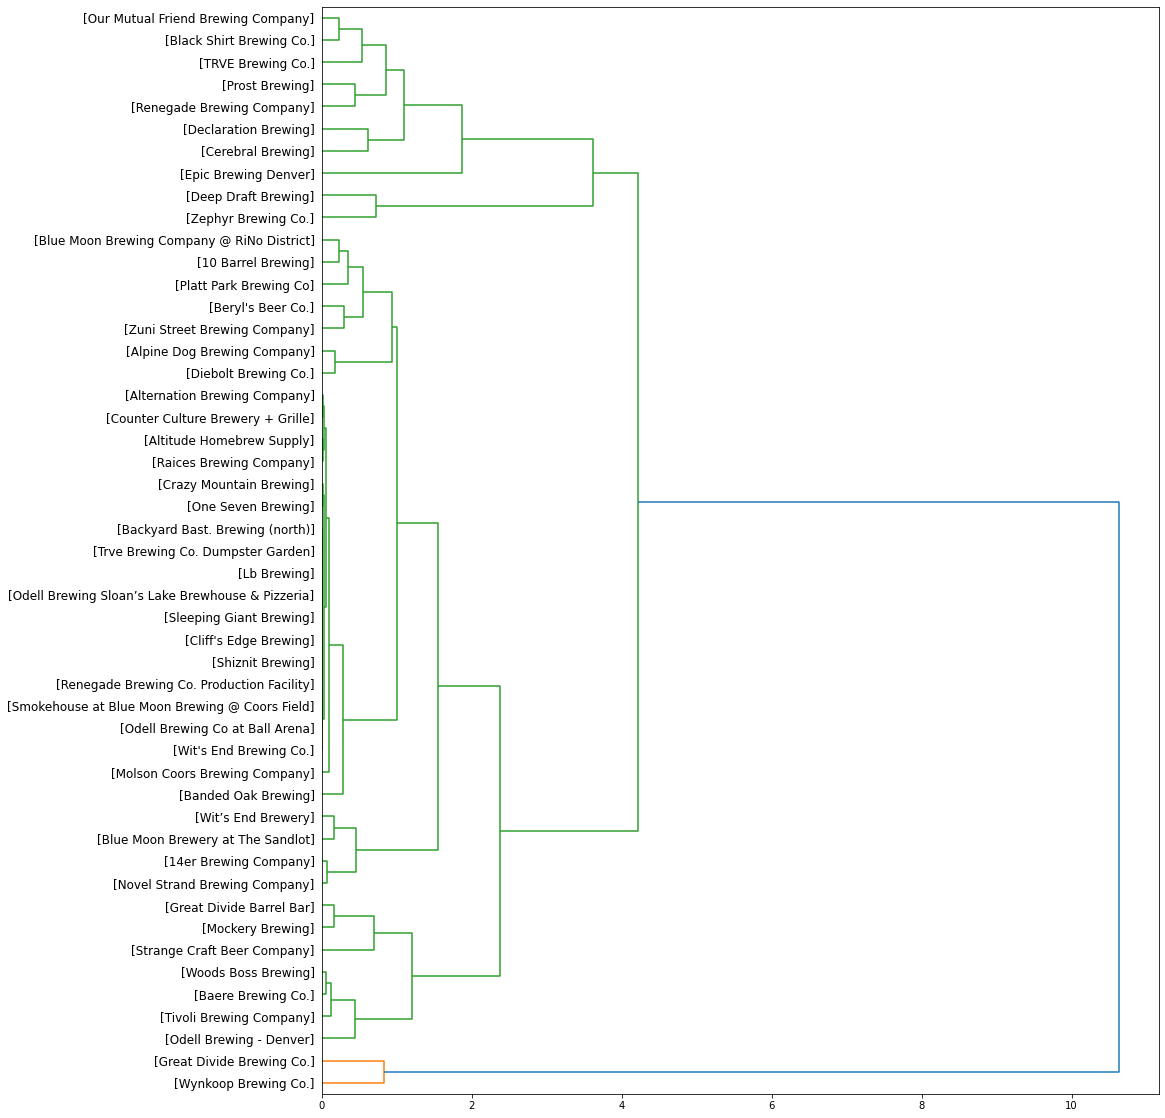

In [17]:
fig = pylab.figure(figsize=(15,20))
def llf(id):
    return '[%s]' % (wanted['name'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

In [18]:
#  Make a map based on the clusters

map_denver = folium.Map(location=[latitude, longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, name, cluster in zip(wanted['lat'], wanted['lng'], wanted['name'], clusters):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

In [19]:
#  Add the clusters to the dataframe
wanted['cluster'] = clusters

In [20]:
wanted.head(15)

,name,id,rating,ratingSignals,lat,lng,tip_count,listed_count,photo_count,cluster
0,Renegade Brewing Company,4e07a5a1d22d658532a784d4,8.700000,196.0,39.730616,-104.999292,43,203,439,7
1,Raices Brewing Company,5c27fded5bc27d0025e6e05b,8.245161,0.0,39.738778,-105.017335,0,1,15,5
2,Wynkoop Brewing Co.,40e0b100f964a5202c041fe3,8.500000,939.0,39.753580,-104.998396,219,537,1412,1
3,Odell Brewing Co at Ball Arena,57479d57498e2fafe38a8479,8.245161,0.0,39.745124,-105.004117,0,0,1,5
4,Great Divide Brewing Co.,4b9e9835f964a52062f236e3,9.000000,784.0,39.753542,-104.988430,168,758,1867,1
5,Cerebral Brewing,54580a0a498e9f3cb6354a86,8.500000,126.0,39.739767,-104.945462,12,90,987,7
6,Odell Brewing - Denver,5ae76e5586bc490039f7089b,9.200000,55.0,39.762190,-104.980964,6,63,178,2
7,Molson Coors Brewing Company,4be16a4a0f03a593972d19b4,8.245161,0.0,39.750053,-104.995508,0,4,39,5
8,Banded Oak Brewing,57535102498eb5969014098f,8.100000,20.0,39.723764,-104.987205,1,12,60,5
9,Prost Brewing,4f63fba1e4b036e3e792341d,8.500000,270.0,39.761438,-105.006699,51,139,603,7


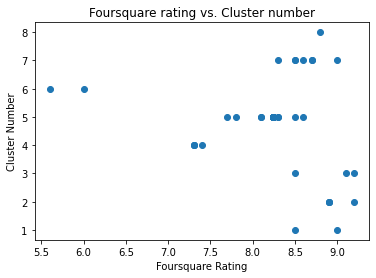

In [21]:
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib import colors as mcol
x = wanted['rating']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Foursquare rating vs. Cluster number')
plt.xlabel('Foursquare Rating')
plt.ylabel('Cluster Number')
plt.show()

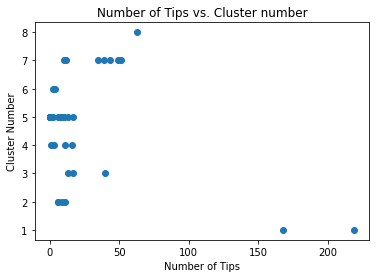

In [22]:
x = wanted['tip_count']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Number of Tips vs. Cluster number')
plt.xlabel('Number of Tips')
plt.ylabel('Cluster Number')
plt.show()

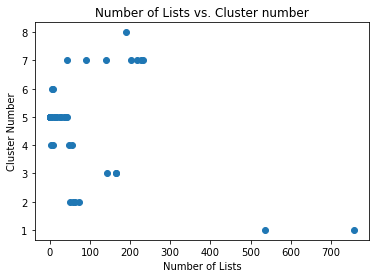

In [23]:
x = wanted['listed_count']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Number of Lists vs. Cluster number')
plt.xlabel('Number of Lists')
plt.ylabel('Cluster Number')
plt.show()

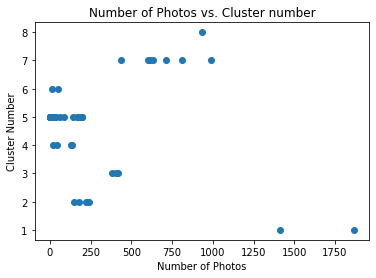

In [24]:
x = wanted['photo_count']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Number of Photos vs. Cluster number')
plt.xlabel('Number of Photos')
plt.ylabel('Cluster Number')
plt.show()

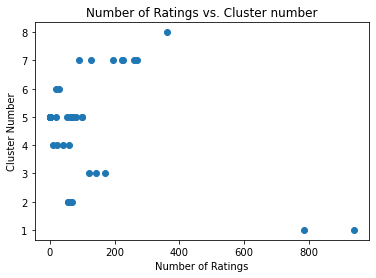

In [25]:
x = wanted['ratingSignals']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Number of Ratings vs. Cluster number')
plt.xlabel('Number of Ratings')
plt.ylabel('Cluster Number')
plt.show()

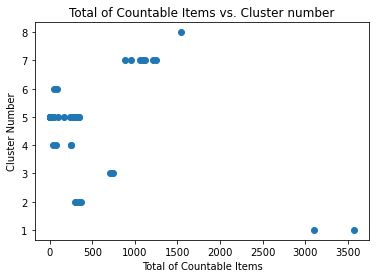

In [26]:
x = wanted['ratingSignals']+wanted['photo_count']+wanted['listed_count']+wanted['tip_count']
y = wanted['cluster']
plt.scatter(x,y,)
plt.title('Total of Countable Items vs. Cluster number')
plt.xlabel('Total of Countable Items')
plt.ylabel('Cluster Number')
plt.show()

In [37]:
sorted_breweries=wanted.sort_values(by='cluster')

## We eliminate clusters 4, 5 and 6 from consideration based on general ratings, and fewer other classifications. 

In [38]:
indexNames = sorted_breweries[ sorted_breweries['cluster'] == 4 ].index
sorted_breweries.drop(indexNames , inplace=True)

In [39]:
indexNames = sorted_breweries[ sorted_breweries['cluster'] == 5 ].index
sorted_breweries.drop(indexNames , inplace=True)

In [40]:
#indexNames = sorted_breweries[ sorted_breweries['cluster'] >= 7 ].index
indexNames = sorted_breweries[ sorted_breweries['cluster'] == 6 ].index
sorted_breweries.drop(indexNames , inplace=True)

In [41]:
#  Make a new map based 

map_denver = folium.Map(location=[latitude, longitude], zoom_start=12)
# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, name, cluster in zip(sorted_breweries['lat'], sorted_breweries['lng'], sorted_breweries['name'], sorted_breweries['cluster']):
    label = '{}, {}'.format(name, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_denver)  
    
map_denver

In [42]:
sorted_breweries.reset_index(inplace=True)

In [43]:
sorted_breweries

,index,name,id,rating,ratingSignals,lat,lng,tip_count,listed_count,photo_count,cluster
0,2,Wynkoop Brewing Co.,40e0b100f964a5202c041fe3,8.5,939.0,39.753580,-104.998396,219,537,1412,1
1,4,Great Divide Brewing Co.,4b9e9835f964a52062f236e3,9.0,784.0,39.753542,-104.988430,168,758,1867,1
2,26,Woods Boss Brewing,5956b528f427de4e1b23a291,8.9,57.0,39.750919,-104.984541,6,57,220,2
3,32,Tivoli Brewing Company,540e0954498e77f0f9129eb5,8.9,70.0,39.745494,-105.005475,11,72,148,2
4,6,Odell Brewing - Denver,5ae76e5586bc490039f7089b,9.2,55.0,39.762190,-104.980964,6,63,178,2
5,16,Baere Brewing Co.,53c1d4ea498e3a62e89b5da4,8.9,66.0,39.721379,-104.987069,9,50,242,2
6,48,Great Divide Barrel Bar,557c84fb498e8dd042b88d97,9.2,144.0,39.770444,-104.978987,13,165,419,3
7,44,Strange Craft Beer Company,4bf48eaccad2c9282f219c99,8.5,170.0,39.737243,-105.014891,40,143,381,3
8,38,Mockery Brewing,54580b6f498e35b5c46dcc4e,9.1,121.0,39.771260,-104.979800,17,165,404,3
9,46,Declaration Brewing,53f4fc13498ef6eddcb20a5f,8.6,91.0,39.679623,-104.990813,10,42,811,7
